## 0. Computer vision libraries in PyTorch

* 'Torch vision' - base domain for PyTorch Computer vision at: 'https://pytorch.org/vision/stable/index.html'
  * torchvision.datasets  get datasets and data loading funcs for computer vision here
  * torchvision.models - get pretrained computer vision models from here
  * torchvision.transforms - functions for manipulating your vision data (images) to be suitable for use with an ML model
  * torch.utils.data.Dataset - Base dataset class for PyTorch
  * torch.utils.data.DataLoader - Creates a Python iterable over a dataset


In [212]:
# import necessary libraries

# PyTorch based
import torch as pt
from torch import nn
import torchvision as tv
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor # converts pil imag3e or np array to FloatTensor of shape (C x H x W)

# Matplotlib for visualization
import matplotlib.pyplot as plt

print(pt.__version__)
print(tv.__version__)

2.0.1+cu118
0.15.2+cu118


### 1. Getting a dataset

The dataset we will be using is FashionMNIST from torchvision.datasets, (a dataset of gray scale images of clothing): https://pytorch.org/vision/main/datasets.html

In [213]:
# Setup training data
import os
print(os.getcwd())
train_data = datasets.FashionMNIST(
    root=f"{os.getcwd()}/data", # where should the file be placed
    train=True, # do we want to get the training dataset
    download=True, # do we want to download the dataset
    transform=ToTensor(), # how do we want to transform the data, 
    target_transform=None # how do we want to transform the labels/targets
    )

test_data = datasets.FashionMNIST(
    root=f"{os.getcwd()}/data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
    )

c:\Users\22gusgam\Desktop\programmering\PyTorch\03


In [214]:
print(len(train_data),len(test_data))

60000 10000


### Visualizing our dataset

#### As numbers

In [215]:
train_data.data.shape # batch size of 60000

torch.Size([60000, 28, 28])

In [216]:
# See the first training example
image, label = train_data[0]
class_names = train_data.classes
class_names[label]

'Ankle boot'

In [217]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [218]:
# Check the shape of our image
print(f"image shape{image.shape} -> [Color channels, height, width]")
print(f"image_label: {class_names[label]}")

image shapetorch.Size([1, 28, 28]) -> [Color channels, height, width]
image_label: Ankle boot


#### As pictures

image shape: torch.Size([1, 28, 28])


Text(0.5, 1.0, 'Ankle boot, 9')

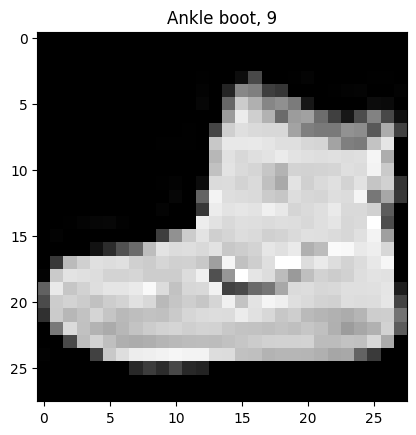

In [219]:
image, label = train_data[0]
print(f"image shape: {image.shape}")
plt.imshow(image.squeeze(),cmap=plt.cm.gray)
plt.title(f"{class_names[label]}, {label}")

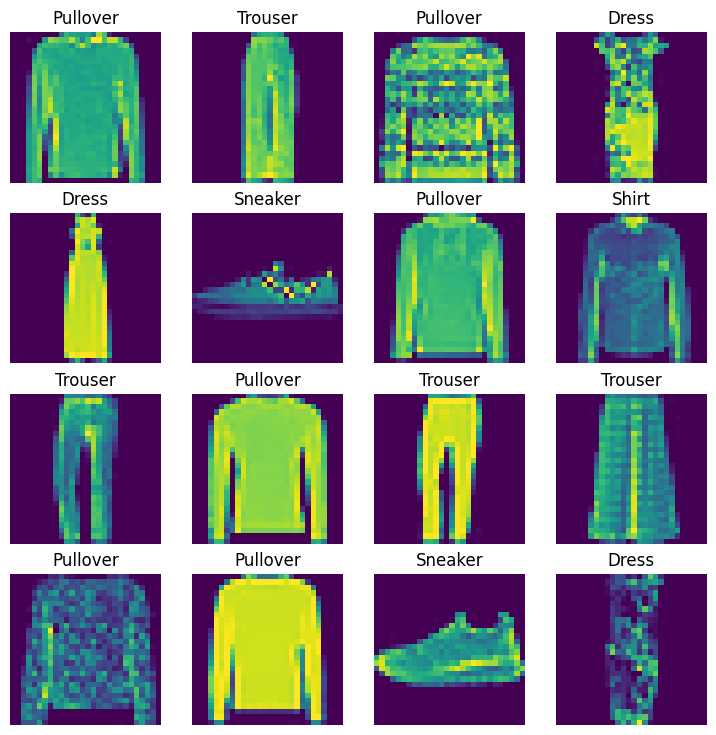

In [220]:
# Plot more images

#pt.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
    random_idx = pt.randint(0, len(train_data), size=[1]).item()
    #print(random_idx,i)
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze()) #, cmap="gray"
    plt.title(class_names[label])
    plt.axis(False)

Is non linearity necessary or not?

### Prepare DataLoader

Right now, our data is in the form of PyTorch Datasets

DataLoaders turn our dataset into a Python iterable
more specifically, we want to turn our data into batches i.e mini-batches

Why do this?
1. It is more computationally efficient, as your computer may not be able to store 60000 images at the same time, therefore we brake it down to ex 32 images at a time (batch size)
2. it gives our nn more chances to update its gradient per epoch (update for each 32 images)

In [221]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into a generator like BataLoader that generates batches
train_dataloader = DataLoader(dataset=train_data, batch_size=32, shuffle=True) # shuffle = True gör att alla värden i arrayen blandas
test_dataloader = DataLoader(dataset=test_data, batch_size=32, shuffle=False)





In [222]:
# Let's check out the dataloader
print(f"DataLoaders: {train_dataloader, test_dataloader}")
print(f"Length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x000002A3B0036290>, <torch.utils.data.dataloader.DataLoader object at 0x000002A3B0191310>)
Length of train_dataloader: 1875 batches of 32
Length of test_dataloader: 313 batches of 32


In [223]:
# Check out what's inside the training dataloader
train_features_batch, training_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, training_labels_batch.shape
# [32 batches, 1 color channel, 28 by, 28 pixels], 32 labels associated with the train_data

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

(-0.5, 27.5, 27.5, -0.5)

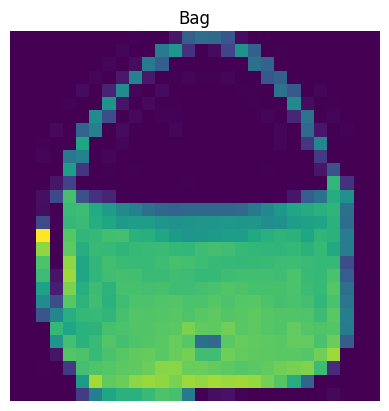

In [224]:
# Show a sample
pt.manual_seed(42)
random_idx = pt.randint(0, len(train_features_batch), size = [1]).item()
img, label = train_features_batch[random_idx], training_labels_batch[random_idx]
plt.imshow(img.squeeze())
plt.title(class_names[label.item()])
plt.axis(False)


### Creating a model

Build a basline ModuleNotFoundError

When starting to build a series of ml modelling experiments it's good to start with a baseline model

A baseline model is a simple model, which you will improve upon with experiments

I.e start simple and add complexity

In [225]:
# Create a flatten layer
flatten_model = nn.Flatten()

# Get a single sample
x = train_features_batch[0]

output = flatten_model(x) # perform a forward pass on the flatten model
# annan metod:
# pt.reshape(x, [1,-1]).shape

# Print results
print(f"Shape before flattening: {x.shape} -> [color_channels, height, width]")
print(f"Shape after flattening: {output.shape} -> [color_channels, height*width]")


Shape before flattening: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Shape after flattening: torch.Size([1, 784]) -> [color_channels, height*width]


In [226]:
pt.manual_seed(42)
from torch import nn

class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_units, output_shape):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # kör genom flatten layer likt i exemplet ovan
            nn.Linear(input_shape, hidden_units),
            #nn.ReLU(),
            nn.Linear(hidden_units, output_shape),
        )
    def forward(self,x):
        return self.layer_stack(x)


In [229]:
device = "cuda" if pt.cuda.is_available() else "cpu"
pt.manual_seed(42)

# Setup model with input parameters
model_0 = FashionMNISTModelV0(
    input_shape=784, # i.e 28*28
    hidden_units=10,
    output_shape=len(class_names) # one for every class
).to(device)
model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [231]:
dummy_x = pt.rand([1,1,28,28])
#print(dummy_x)
print(model_0(dummy_x))

tensor([[-0.1680,  0.2322,  0.2701,  0.0274,  0.6386,  0.3092,  0.3212,  0.2810,
         -0.1581, -0.1608]], grad_fn=<AddmmBackward0>)


### Setup loss, optimizer and evaluation metrics

* Loss function - Since we are working with multiclass data, our loss function will be nn.CrossEntropyLoss()

* Optimizer - Our optimizer will be SGD (stochastic gradient descent)
* Evaluation metric - since we are working on a classification problem, lets use accuracy oas our evaluation metric

In [4]:
import importLib
#C:\Users\22gusgam\Desktop\programmering\PyTorch\ml toolkit\helper_functions.py

ModuleNotFoundError: No module named 'C:/Users/22gusgam/Desktop/programmering/PyTorch/import_fn'